# user_genre_preference

유저의 선호 장르를 이용한 영화 추천








In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from tqdm import tqdm
from datetime import datetime, timedelta

In [2]:
data_dir = "/data/ephemeral/home/level2-recsys-movierecommendation-recsys-04-lv3/.data"

train_ratings = pd.read_csv(f"{data_dir}/train/train_ratings.csv", sep=',')
directors = pd.read_csv(f"{data_dir}/train/directors.tsv", sep='\t')
genres = pd.read_csv(f"{data_dir}/train/genres.tsv", sep='\t')
titles = pd.read_csv(f"{data_dir}/train/titles.tsv", sep='\t')
writers = pd.read_csv(f"{data_dir}/train/writers.tsv", sep='\t')
years = pd.read_csv(f"{data_dir}/train/years.tsv", sep='\t')

# 결측치

In [3]:
# 결측치 없음
print(train_ratings.isna().sum().sum())
print(titles.isna().sum().sum())
print(genres.isna().sum().sum())
print(directors.isna().sum().sum())
print(writers.isna().sum().sum())
print(years.isna().sum().sum())

0
0
0
0
0
0


# 하나의 train df로 합치기

In [4]:
# 칼럼명 출력
print(train_ratings.columns.tolist())
print(titles.columns.tolist())
print(genres.columns.tolist())
print(directors.columns.tolist())
print(writers.columns.tolist())
print(years.columns.tolist())

['user', 'item', 'time']
['item', 'title']
['item', 'genre']
['item', 'director']
['item', 'writer']
['item', 'year']


In [17]:
def get_train_df(data_dir):
    train_ratings = pd.read_csv(f"{data_dir}/train/train_ratings.csv", sep=',')
    directors = pd.read_csv(f"{data_dir}/train/directors.tsv", sep='\t')
    genres = pd.read_csv(f"{data_dir}/train/genres.tsv", sep='\t')
    titles = pd.read_csv(f"{data_dir}/train/titles.tsv", sep='\t')
    writers = pd.read_csv(f"{data_dir}/train/writers.tsv", sep='\t')
    years = pd.read_csv(f"{data_dir}/train/years.tsv", sep='\t')

    df_train = pd.merge(train_ratings, titles, how='outer', on='item')
    df_train = pd.merge(df_train, genres, how='outer', on='item')
    df_train = pd.merge(df_train, directors, how='outer', on='item')
    df_train = pd.merge(df_train, writers, how='outer', on='item')
    df_train = pd.merge(df_train, years, how='outer', on='item')
    df_train = df_train.dropna().reset_index(drop=True)

    return df_train


data_dir = "/data/ephemeral/home/level2-recsys-movierecommendation-recsys-04-lv3/.data"
df_train = get_train_df(data_dir)

print(df_train.shape)
df_train

(46636737, 8)


,user,item,time,title,genre,director,writer,year
0,11,1,1230858821,Toy Story (1995),Adventure,nm0005124,nm0004056,1995.0
1,11,1,1230858821,Toy Story (1995),Adventure,nm0005124,nm0005124,1995.0
2,11,1,1230858821,Toy Story (1995),Adventure,nm0005124,nm0169505,1995.0
3,11,1,1230858821,Toy Story (1995),Adventure,nm0005124,nm0230032,1995.0
4,11,1,1230858821,Toy Story (1995),Adventure,nm0005124,nm0710020,1995.0
...,...,...,...,...,...,...,...,...
46636732,138166,119141,1420044319,The Interview (2014),Action,nm1698571,nm1698571,2014.0
46636733,138166,119141,1420044319,The Interview (2014),Comedy,nm0736622,nm0736622,2014.0
46636734,138166,119141,1420044319,The Interview (2014),Comedy,nm0736622,nm1698571,2014.0
46636735,138166,119141,1420044319,The Interview (2014),Comedy,nm1698571,nm0736622,2014.0


In [10]:
# Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.
'''
KST는 UTC보다 9시간 빠르므로, 타임스탬프에 9시간을 더해주면 됩니다.

'''
# UTC 타임스탬프를 KST로 변환하는 함수
def convert_utc_to_kst(utc_timestamp):
    # UTC 타임스탬프를 datetime 객체로 변환
    utc_time = datetime.utcfromtimestamp(utc_timestamp)
    # KST는 UTC보다 9시간 빠름
    kst_time = utc_time + timedelta(hours=9)
    return kst_time


train_ratings = pd.read_csv(f"{data_dir}/train/train_ratings.csv", sep=',')

# train_ratings의 'time' 열을 KST로 변환
train_ratings['time_kst'] = train_ratings['time'].apply(convert_utc_to_kst)

# 'time_kst'에서 년도만 추출하여 새로운 'year' 열 생성
train_ratings['year'] = train_ratings['time_kst'].dt.year

train_ratings

,user,item,time,time_kst,year
0,11,4643,1230782529,2009-01-01 13:02:09,2009
1,11,170,1230782534,2009-01-01 13:02:14,2009
2,11,531,1230782539,2009-01-01 13:02:19,2009
3,11,616,1230782542,2009-01-01 13:02:22,2009
4,11,2140,1230782563,2009-01-01 13:02:43,2009
...,...,...,...,...,...
5154466,138493,44022,1260209449,2009-12-08 03:10:49,2009
5154467,138493,4958,1260209482,2009-12-08 03:11:22,2009
5154468,138493,68319,1260209720,2009-12-08 03:15:20,2009
5154469,138493,40819,1260209726,2009-12-08 03:15:26,2009


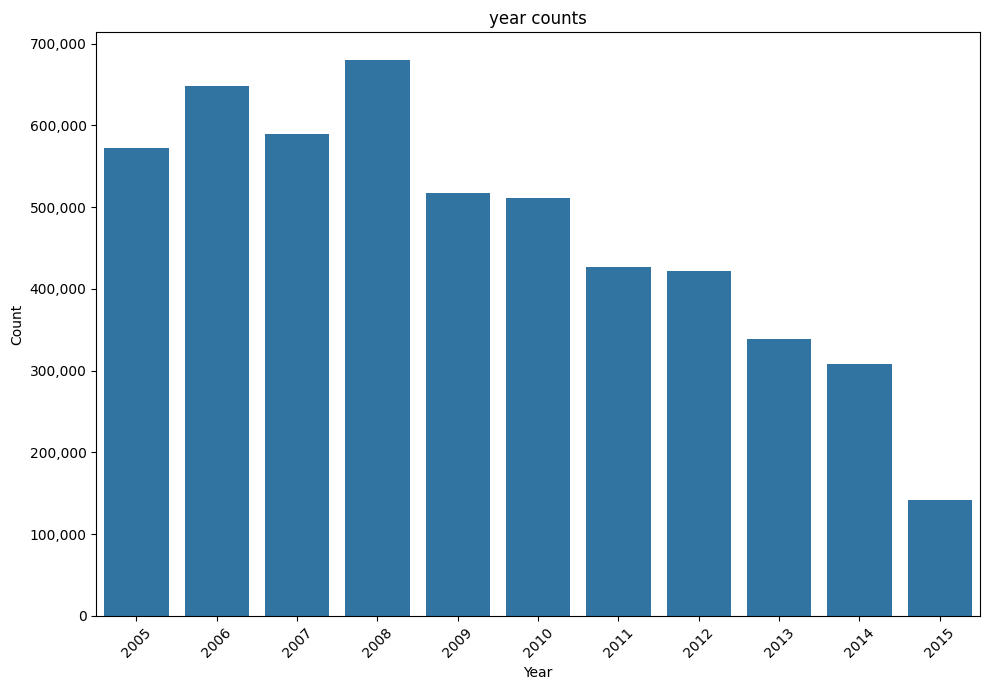

In [11]:
year_cnt = train_ratings.groupby(by='year')['user'].count().reset_index(name='count')

plt.figure(figsize=(10, 7))

ax = sns.barplot(x='year', y='count', data=year_cnt)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))  # y축에 천 단위 구분 기호 추가

plt.title('year counts')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# 특정 유저의 rating year 확인하기
user = 11

print(train_ratings[train_ratings['user'] == user].year.unique())

train_ratings[train_ratings['user'] == user]

[2009 2011]


,user,item,time,time_kst,year
0,11,4643,1230782529,2009-01-01 13:02:09,2009
1,11,170,1230782534,2009-01-01 13:02:14,2009
2,11,531,1230782539,2009-01-01 13:02:19,2009
3,11,616,1230782542,2009-01-01 13:02:22,2009
4,11,2140,1230782563,2009-01-01 13:02:43,2009
...,...,...,...,...,...
371,11,48738,1294796106,2011-01-12 10:35:06,2011
372,11,6291,1294796113,2011-01-12 10:35:13,2011
373,11,46578,1294796119,2011-01-12 10:35:19,2011
374,11,7153,1294796132,2011-01-12 10:35:32,2011


# 유저별 선호 장르찾기

In [13]:
# 유저별 장르 카운트
user_genre_counts = df_train.groupby(['user', 'genre']).size().reset_index(name='count')

user_genre_counts

,user,genre,count
0,11,Action,454
1,11,Adventure,546
2,11,Animation,505
3,11,Children,489
4,11,Comedy,305
...,...,...,...
513693,138493,Romance,201
513694,138493,Sci-Fi,135
513695,138493,Thriller,147
513696,138493,War,22


In [14]:
# 유저별로 가장 많이 본 장르 찾기
user_preferences = user_genre_counts.loc[user_genre_counts.groupby('user')['count'].idxmax()]
user_preferences.reset_index(drop=True, inplace=True)

user_preferences

,user,genre,count
0,11,Adventure,546
1,14,Children,547
2,18,Drama,83
3,25,Adventure,182
4,31,Adventure,368
...,...,...,...
31355,138473,Drama,66
31356,138475,Drama,136
31357,138486,Adventure,296
31358,138492,Comedy,100


In [15]:
# 유저별로 가장 적게 본 장르 찾기
user_preferences_min = user_genre_counts.loc[user_genre_counts.groupby('user')['count'].idxmin()]
user_preferences_min.reset_index(drop=True, inplace=True)

user_preferences_min

,user,genre,count
0,11,Film-Noir,2
1,14,Western,5
2,18,Film-Noir,2
3,25,War,4
4,31,Horror,17
...,...,...,...
31355,138473,Western,1
31356,138475,Documentary,3
31357,138486,Western,2
31358,138492,Mystery,1


random_users:  [117874  30467 102309  37896  58309  13419  11718  70327   1198  51775]


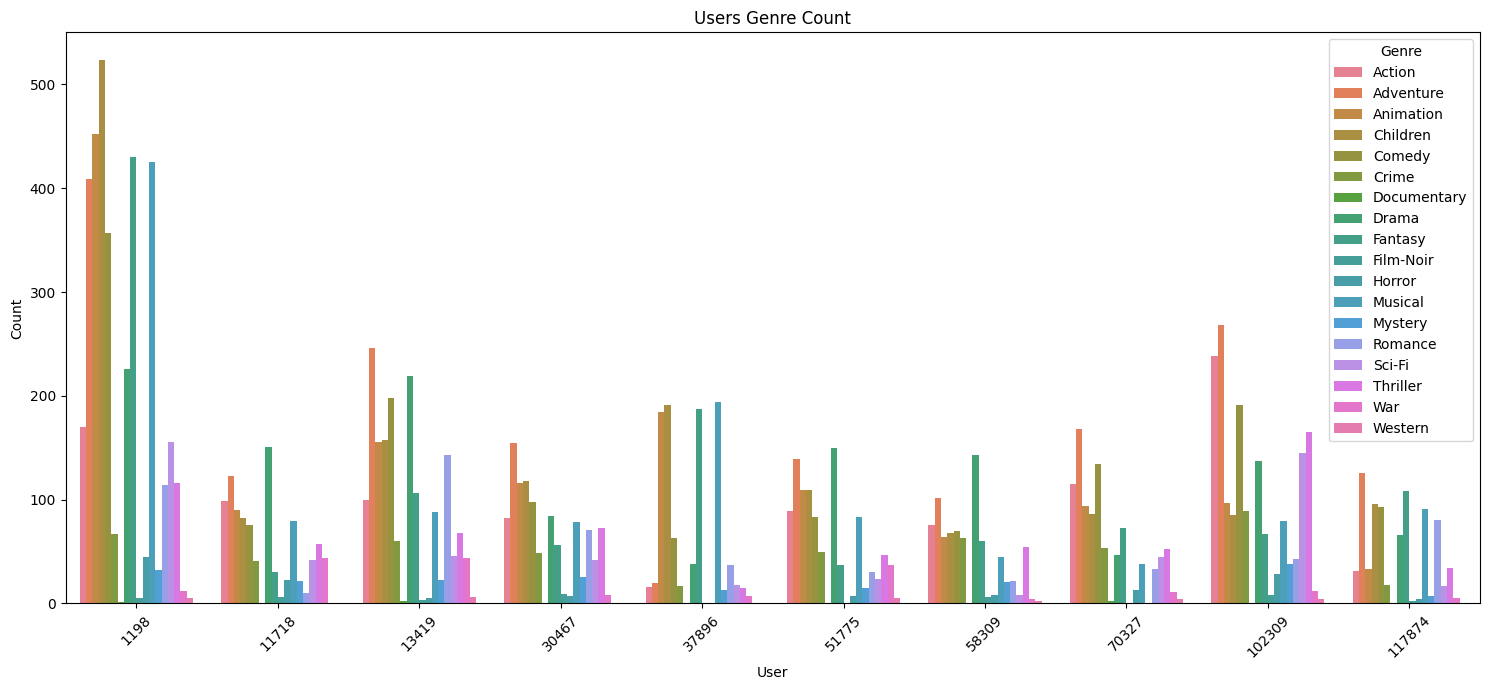

유저별 가장 많이 본 장르
         user      genre  count
275      1198   Children    524
2650    11718      Drama    151
3050    13419  Adventure    246
6981    30467  Adventure    155
8672    37896    Musical    194
11813   51775      Drama    150
13307   58309      Drama    143
15991   70327  Adventure    168
23329  102309  Adventure    268
26803  117874  Adventure    126

유저별 가장 적게 본 장르
         user        genre  count
275      1198  Documentary      1
2650    11718    Film-Noir      6
3050    13419  Documentary      2
6981    30467       Horror      7
8672    37896          War      7
11813   51775      Western      5
13307   58309      Western      2
15991   70327  Documentary      2
23329  102309      Western      4
26803  117874    Film-Noir      2


In [16]:
# 유저 리스트 추출
unique_users = df_train['user'].unique()

# 랜덤으로 10명의 유저 추출
random_users = pd.Series(unique_users).sample(10, random_state=42).values
print("random_users: ", random_users)

user_genre_counts_rand10 = user_genre_counts[user_genre_counts['user'].isin(random_users)]

# 바 차트 생성
plt.figure(figsize=(15, 7))
sns.barplot(x='user', y='count', hue='genre', data=user_genre_counts_rand10)
plt.title('Users Genre Count')
plt.xlabel('User')
plt.ylabel('Count')
plt.legend(title='Genre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 가장 많이 본 장르에 장르명 추가
print("유저별 가장 많이 본 장르")
user_preference_genre_counts_rand10 = user_preferences[user_preferences['user'].isin(random_users)]
print(user_preference_genre_counts_rand10)

# 가장 적게 본 장르에 장르명 추가
print("\n유저별 가장 적게 본 장르")
user_preference_genre_counts_rand10_min = user_preferences_min[user_preferences_min['user'].isin(random_users)]
print(user_preference_genre_counts_rand10_min)

- 유저별로 선호하는 장르를 주로 보는 경향이 보임

## 랜덤

In [ ]:
# 영화 추천 함수
def get_recommendations(user_preferences: pd.DataFrame, df_train: pd.DataFrame) -> pd.DataFrame:
    recommendations = pd.DataFrame()   # 빈 데이터프레임 생성
    watched_movies = df_train[['user', 'title']].drop_duplicates()  # 이미 본 영화 목록 추출

    '''이 부분을 추가해서 속도를 향상 시킴'''
    df_train = df_train[['title', 'item', 'genre', 'year']].drop_duplicates() 

    for index, row in tqdm(user_preferences.iterrows(), total=user_preferences.shape[0]):
        user = row['user']   # 유저 ID
        genre = row['genre'] # 선호 장르
        rec_genre_movies = df_train[df_train['genre'] == genre][['title', 'item', 'year']].drop_duplicates()  # 해당 장르에 속하는 영화 추출
        rec_genre_movies = rec_genre_movies[~rec_genre_movies['title'].isin(watched_movies[watched_movies['user'] == user]['title'])]  # 이미 유저가 본 영화 제외

        # recommended_movies = rec_genre_movies.sort_values(by='year', ascending=False).head(10)  # 개봉년도 기준 최신순 정렬 후 상위 10개 추출
        recommended_movies = rec_genre_movies.sample(10, random_state=42)  # 랜덤으로 10개 추출

        recommended_movies['user'] = user  # 추천된 영화 목록에 유저 ID 추가
        recommendations = pd.concat([recommendations, recommended_movies], ignore_index=True)  # 추천된 영화들을 recommendations 데이터프레임에 추가
        recommendations = recommendations[['user', 'item', 'title']]  # 칼럼 순서 변경

    recommendations = recommendations[['user', 'item']]   # 필요한 열만 선택

    return recommendations


# 영화 추천 실행
recommendations = get_recommendations(user_preferences=user_preferences, df_train=df_train)

saved_path = "/data/ephemeral/home/level2-recsys-movierecommendation-recsys-04-lv3/.saved"
recommendations.to_csv(f"{saved_path}/submission_preference_random.csv", index=False)

recommendations

## 최신순

In [ ]:
# 영화 추천 함수
def get_recommendations(user_preferences: pd.DataFrame, df_train: pd.DataFrame) -> pd.DataFrame:
    recommendations = pd.DataFrame()   # 빈 데이터프레임 생성
    watched_movies = df_train[['user', 'title']].drop_duplicates()  # 이미 본 영화 목록 추출

    '''이 부분을 추가해서 속도를 향상 시킴'''
    df_train = df_train[['title', 'item', 'genre', 'year']].drop_duplicates() 

    for index, row in tqdm(user_preferences.iterrows(), total=user_preferences.shape[0]):
        user = row['user']   # 유저 ID
        genre = row['genre'] # 선호 장르
        rec_genre_movies = df_train[df_train['genre'] == genre][['title', 'item', 'year']].drop_duplicates()  # 해당 장르에 속하는 영화 추출
        rec_genre_movies = rec_genre_movies[~rec_genre_movies['title'].isin(watched_movies[watched_movies['user'] == user]['title'])]  # 이미 유저가 본 영화 제외

        recommended_movies = rec_genre_movies.sort_values(by='year', ascending=False).head(10)  # 개봉년도 기준 최신순 정렬 후 상위 10개 추출
        # recommended_movies = rec_genre_movies.sample(10, random_state=42)  # 랜덤으로 10개 추출

        recommended_movies['user'] = user  # 추천된 영화 목록에 유저 ID 추가
        recommendations = pd.concat([recommendations, recommended_movies], ignore_index=True)  # 추천된 영화들을 recommendations 데이터프레임에 추가
        recommendations = recommendations[['user', 'item', 'title']]  # 칼럼 순서 변경

    recommendations = recommendations[['user', 'item']]   # 필요한 열만 선택

    return recommendations


# 영화 추천 실행
recommendations = get_recommendations(user_preferences=user_preferences, df_train=df_train)

saved_path = "/data/ephemeral/home/level2-recsys-movierecommendation-recsys-04-lv3/.saved"
recommendations.to_csv(f"{saved_path}/submission_preference_recent.csv", index=False)

recommendations

## 오래된순

In [ ]:
# 영화 추천 함수
def get_recommendations(user_preferences: pd.DataFrame, df_train: pd.DataFrame) -> pd.DataFrame:
    recommendations = pd.DataFrame()   # 빈 데이터프레임 생성
    watched_movies = df_train[['user', 'title']].drop_duplicates()  # 이미 본 영화 목록 추출

    '''이 부분을 추가해서 속도를 향상 시킴'''
    df_train = df_train[['title', 'item', 'genre', 'year']].drop_duplicates() 

    for index, row in tqdm(user_preferences.iterrows(), total=user_preferences.shape[0]):
        user = row['user']   # 유저 ID
        genre = row['genre'] # 선호 장르
        rec_genre_movies = df_train[df_train['genre'] == genre][['title', 'item', 'year']].drop_duplicates()  # 해당 장르에 속하는 영화 추출
        rec_genre_movies = rec_genre_movies[~rec_genre_movies['title'].isin(watched_movies[watched_movies['user'] == user]['title'])]  # 이미 유저가 본 영화 제외

        recommended_movies = rec_genre_movies.sort_values(by='year', ascending=True).head(10)  # 개봉년도 기준 오래된순 정렬 후 상위 10개 추출
        # recommended_movies = rec_genre_movies.sample(10, random_state=42)  # 랜덤으로 10개 추출

        recommended_movies['user'] = user  # 추천된 영화 목록에 유저 ID 추가
        recommendations = pd.concat([recommendations, recommended_movies], ignore_index=True)  # 추천된 영화들을 recommendations 데이터프레임에 추가
        recommendations = recommendations[['user', 'item', 'title']]  # 칼럼 순서 변경

    recommendations = recommendations[['user', 'item']]   # 필요한 열만 선택

    return recommendations


# 영화 추천 실행
recommendations = get_recommendations(user_preferences=user_preferences, df_train=df_train)

saved_path = "/data/ephemeral/home/level2-recsys-movierecommendation-recsys-04-lv3/.saved"
recommendations.to_csv(f"{saved_path}/submission_preference_old.csv", index=False)

recommendations